# Imports & Downloads

In [1]:
!which python

/home/kate/nn/env/bin/python


In [2]:
!pip freeze

argon2-cffi==20.1.0
async-generator==1.10
attrs==20.3.0
backcall==0.2.0
bleach==3.3.0
cffi==1.14.5
dataclasses==0.8
decorator==4.4.2
defusedxml==0.7.1
entrypoints==0.3
importlib-metadata==3.7.2
ipykernel==5.5.0
ipython==7.16.1
ipython-genutils==0.2.0
ipywidgets==7.6.3
jedi==0.18.0
Jinja2==2.11.3
jsonschema==3.2.0
jupyter==1.0.0
jupyter-client==6.1.11
jupyter-console==6.2.0
jupyter-core==4.7.1
jupyterlab-pygments==0.1.2
jupyterlab-widgets==1.0.0
MarkupSafe==1.1.1
mistune==0.8.4
nbclient==0.5.3
nbconvert==6.0.7
nbformat==5.1.2
nest-asyncio==1.5.1
notebook==6.2.0
numpy==1.19.5
packaging==20.9
pandocfilters==1.4.3
parso==0.8.1
pexpect==4.8.0
pickleshare==0.7.5
Pillow==8.1.2
pkg-resources==0.0.0
prometheus-client==0.9.0
prompt-toolkit==3.0.16
ptyprocess==0.7.0
pycparser==2.20
Pygments==2.8.1
pyparsing==2.4.7
pyrsistent==0.17.3
python-dateutil==2.8.1
pyzmq==22.0.3
qtconsole==5.0.2
QtPy==1.9.0
Send2Trash==1.5.0
six==1.15.0
terminado==0.9.2
testpath==0.4.4
torch==1.8.0+cu111
torchaudio==0.8.0


In [2]:
# import pyforest
# import dlib
# from imutils import face_utils
# from google.colab.patches import cv2_imshow
import sys
import os
import random
from math import *  
import numpy as np
from numpy import ones,vstack
from numpy.linalg import lstsq
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import imutils
import time


import cv2
import xml.etree.ElementTree as ET
from PIL import Image
from collections import OrderedDict
from skimage import io, transform

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image
import google
# from google.colab import files

import gdown
# from google.colab.patches import cv2_imshow

In [3]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
from datetime import date

In [5]:
train_metadatapath = r"WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_train.txt"
test_metadatapath = r"WFLW_annotations/list_98pt_rect_attr_train_test/list_98pt_rect_attr_test.txt"
our_test_metadatapath = r"ourAnnotations_jpg.txt"
k_metadatapath = r"annotations_k.txt"
y_metadatapath = r"annotations_y.txt"

images_dir = r"WFLW_images"
test_images_dir = r"our_images"


# Classes & Functions

In [6]:
from numpy.polynomial import Polynomial as P

def get_info(annotation):
  path_to_image = annotation[-1]
  key_points = np.array(annotation[:2*98], np.float).reshape((-1, 2))
  crop = list(map(float, annotation[2*98:2*98+4]))
  crop = list(map(int, crop))

  return path_to_image, key_points, crop

def compute_line_2(coors):
  # Define the known points
  x_coor = coors[:,0]
  y_coor = coors[:,1]
  if x_coor[0] == x_coor[1]:
    x_coor[0] = x_coor[0] + 0.001
  x_coor= x_coor*224

  if y_coor[0] == y_coor[1]:
    y_coor[0] = y_coor[0] + 0.001
  y_coor= y_coor*224  
  # Calculate the coefficients. This line answers the initial question. 
  # coefficients = np.polynomial.polynomial.polyfit(x_coor, y_coor, 1)  
  coefficients = P.fit(x_coor, y_coor, 1)
  return coefficients


class Halfface(object):
  def __init__ (self, central_coors = [51, 79]):
    self.central_coors = central_coors
    pass
  
  def __call__(self, sample):
    polynomial = compute_line_2(sample['landmarks'][self.central_coors])
    slope = polynomial.coef[1]
    
    image_occlude_left = sample['images'].cuda().detach().clone()
    image_occlude_right = sample['images'].cuda().detach().clone()
    image_occlude_left = sample['images'].cuda().detach().clone()
    image_occlude_right = sample['images'].cuda().detach().clone()
    image = sample['images'].cpu().detach().clone().permute((1, 2, 0))
    img = np.array(image)
    image_blur = cv2.GaussianBlur(img, (65,65), 10)
    blurred_image = torch.tensor(image_blur).cuda()
    
    indexes = np.arange(224)
    y_indexes = polynomial(indexes)

    y_annotations_faltten = np.reshape(sample['landmarks'].numpy()[:,1], [98,-1]).squeeze()*224
    x_annotations_faltten = np.reshape(sample['landmarks'].numpy()[:,0], [98,-1]).squeeze()*224

    y_poly_annotations_faltten = polynomial(x_annotations_faltten).squeeze()
    
    for i in range(224):
      mask = (i-y_indexes>0)
      invert_mask =  np.invert(mask)
      if slope>=0:
        image_occlude_left[:,i,mask] = 0
        image_occlude_right[:,i,invert_mask] = 0
        image_occlude_left = image_occlude_left.permute(1, 2, 0)
        image_occlude_left[i,mask] = blurred_image[i, mask]
        image_occlude_left = image_occlude_left.permute(2, 0, 1)
        image_occlude_right = image_occlude_right.permute(1, 2, 0)
        image_occlude_right[i,invert_mask] = blurred_image[i, invert_mask]
        image_occlude_right = image_occlude_right.permute(2, 0, 1)
      else:
        # image_occlude_left[:,i,invert_mask] = 0
        # image_occlude_right[:,i,mask] = 0
        image_occlude_left = image_occlude_left.permute(1, 2, 0)
        image_occlude_left[i,invert_mask] = blurred_image[i, invert_mask]
        image_occlude_left = image_occlude_left.permute(2, 0, 1)
        image_occlude_right = image_occlude_right.permute(1, 2, 0)
        image_occlude_right[i,mask] = blurred_image[i, mask]
        image_occlude_right = image_occlude_right.permute(2, 0, 1)
        
    ## TODO: put False's for the nose points
    
    annotations_mask = (y_annotations_faltten-y_poly_annotations_faltten)
    annotations_mask = (annotations_mask>0)

    annotations_invert_mask = np.invert(annotations_mask)
    if slope>=0:
      sample['landmarks_occlude_left'] = annotations_mask
      sample['landmarks_occlude_right'] = annotations_invert_mask
    else:
      sample['landmarks_occlude_right'] = annotations_mask
      sample['landmarks_occlude_left'] = annotations_invert_mask

    sample['images_occlude_left'] = image_occlude_left
    sample['images_occlude_right'] = image_occlude_right
    # left = ((indexes - y_indexes)<0)
    # print(left)
    # image[:,:,left ] = 0
    # sample['images'] = image
    return sample

class Rotation(object):
  """Rotate by a random angle from a given range ."""

  def __init__(self, maxangle=10):
    self.maxangle = maxangle

  def __call__(self, sample):
    angle =  random.randint(-self.maxangle, +self.maxangle)
    image = sample['images']
    image =  TF.rotate(image.cuda(), angle)
    sample['images'] = image

    transformation_matrix = torch.tensor([
      [+cos(radians(angle)), -sin(radians(angle))],
      [+sin(radians(angle)), +cos(radians(angle))]
    ])
    landmarks = sample['landmarks'] - 0.5
    new_landmarks = np.matmul(landmarks, transformation_matrix)
    new_landmarks = new_landmarks + 0.5
    sample['landmarks'] = new_landmarks
    return sample

class Crop_face_and_resize(object):

  def __init__(self):
    pass

  def __call__(self, sample):
    image, landmarks, crops = sample['images'], sample['landmarks'], sample['crops']
    left = crops[0]
    top = crops[1]
    bbox_width = crops[2]-crops[0]
    bbox_height = crops[3]-crops[1]
    img = torchvision.transforms.functional.resized_crop(image.cuda(), crops[1], crops[0],(crops[3]-crops[1]), (crops[2]-crops[0]),(224,224))  
    sample['images'] = img 
    landmarks = landmarks - torch.tensor([left, top])
    landmarks = landmarks /torch.tensor( [bbox_width,bbox_height])         
    sample['landmarks'] = landmarks
    return sample


class Color_jitter(object):
  """Randomly change the brightness, contrast and saturation of an image.
  in this augmentation  we convert the np array to pill in order to use transforms  
"""

  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    # im_pil = Image.fromarray((image* 255).astype(np.uint8))
    color_jitter = transforms.ColorJitter(brightness=0.1,
                                      contrast=0.1,
                                      saturation=0.1,
                                      hue=0.1)
    pill_img_aug = color_jitter(image.cuda()) 
    sample['images'] =pill_img_aug
    return sample

class ImagenetNormalize(object):
  """ToTensor."""
  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    imagenet_norm = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    norm_image = imagenet_norm(image) 
    sample['images'] =norm_image
    return sample

class Normalize(object):
  """ToTensor."""
  def __init__(self):
    pass
  def __call__(self, sample ):

    image = sample['images'] 
    ConvertImageDtype = transforms.ConvertImageDtype(torch.float)
    images_norm = transforms.Normalize(mean=[0.5595, 0.4268, 0.3663],
                             std=[0.2584, 0.2369, 0.2182])
    converted_images = ConvertImageDtype(image.cuda())
    norm_image = images_norm(converted_images.cuda()) 

    sample['images'] =norm_image
    return sample


In [7]:
class FaceLandmarksDataset(Dataset):

    def __init__(self,images_dir, metadatapath, transform=None, include_landmarks=True):

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        self.metadatapath = metadatapath
        self.images_dir = images_dir
        self.include_landmarks = include_landmarks
        with open(self.metadatapath, 'r') as filehandle:
            for line in filehandle:
                # remove linebreak which is the last character of the string
                face_instance = line[:-1].split(' ')
                self.image_filenames.append( face_instance[-1])
                # self.landmarks.append([float(i) for i in face_instance[:196]] )
                # self.crops.append([float(i) for i in face_instance[196:200]] )
                self.crops.append(list(map(int,face_instance[196:200])))
                if include_landmarks:
                  landmark = []
                  for num in range(98):
                      x_coordinate = (float(face_instance[num*2]))
                      y_coordinate = float(face_instance[num*2 + 1])
                      landmark.append(list(map(int,[x_coordinate, y_coordinate])))
                  self.landmarks.append(landmark)
        if self.include_landmarks:
          self.landmarks =  torch.as_tensor(self.landmarks , dtype=torch.float)
          assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        img_name = os.path.join(self.images_dir, self.image_filenames[index])
        image = read_image(img_name)
        if self.include_landmarks:
          landmarks = self.landmarks[index]
          crops = self.crops[index]
          sample = {'images': image, 'landmarks': landmarks , 'crops':crops  }
          if self.transform:
              sample = self.transform(sample)
          sample['landmarks'] = sample['landmarks'] - 0.5
        else:
          sample = {'images': image }
        return sample

In [8]:
def visualize_dataset(dataset , w,h, num_images = 4, type = None):
  rows = ceil(num_images/4)
  fig = plt.figure(figsize=(w, h))
  for i in range(num_images):
      sample = dataset[i]
      if (dataset.include_landmarks==True):
        if type== "left":
          landmarks_occlude_left = sample['landmarks_occlude_left']
          image , landmarks = sample['images_occlude_left'] , sample['landmarks']
          landmarks[sample['landmarks_occlude_left']]=0
        elif type=="right":
          landmarks_occlude_right = sample['landmarks_occlude_right']
          image , landmarks = sample['images_occlude_right'] , sample['landmarks']
          landmarks[sample['landmarks_occlude_right']]=0
        else:
          image, landmarks = sample['images'] , sample['landmarks']

        image = image.cpu() 
        image = image.permute(1, 2, 0)
        shape =  image.shape
        fig.add_subplot(rows, 4, i+1)
        plt.imshow(image)
        plt.scatter((landmarks[:, 0] +0.5)*shape[1], (landmarks[:, 1] + 0.5)*shape[0], s=30, marker='.', c='r')
        # plt.scatter((landmarks[51, 0] +0.5)*shape[1], (landmarks[51, 1] + 0.5)*shape[0], s=30, marker='.', c='b')
        # plt.scatter((landmarks[79, 0] +0.5)*shape[1], (landmarks[79, 1] + 0.5)*shape[0], s=30, marker='.', c='b')

      else:
        image = sample['images'] 
        image = image.cpu() 
        image = image.permute(1, 2, 0)
        shape =  image.shape
        fig.add_subplot(rows, 4, i+1)
        plt.imshow(image)
  plt.show()
  return


In [9]:
def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.6f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.6f " % (step, total_step, loss))
        
    sys.stdout.flush()


In [10]:
def compute_line(coors):
  # Define the known points
  x_coor = coors[:, 0]
  y_coor = coors[:, 1]

  # Calculate the coefficients. This line answers the initial question. 
  coefficients = np.polyfit(x_coor, y_coor, 1)

  # Let's compute the values of the line...
  polynomial = np.poly1d(coefficients)

  return polynomial

In [11]:
def evaluate_model(test_loader, model, visualize=True, halves=True):
  model = model.cuda()
  start_time = time.time()
  full_error = []
  half_error = []
  test_it = iter(test_loader)
  # for samples in test_loader:
  model.eval()
  with torch.no_grad():
    for step in range(1,len(test_loader)+1):
      samples = next(test_it)
#       images, landmarks = samples['images_occlude_right'], samples['landmarks']
      images, landmarks = samples['images'], samples['landmarks']
      images = images.cuda()
      landmarks = (landmarks + 0.5) * 224

      predictions = (model(images).cpu() + 0.5) * 224
      predictions = predictions.view(-1,98,2)

      full_error.append(NME(predictions, landmarks))
      # half_error.append(NME(predictions, landmarks, half=True))
      if visualize:
        plt.figure(figsize=(10,40))
        for img_num in range(8):
            plt.subplot(8,1,img_num+1)
            image = images[img_num].cpu().permute(1, 2, 0)
            plt.imshow(image)
            # plt.imshow(cv2.cvtColor(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cv2.COLOR_BGR2RGB) )
            plt.scatter(predictions[img_num,:,0], predictions[img_num,:,1], c = 'r', s = 5)
#             plt.scatter(landmarks[img_num,:,0], landmarks[img_num,:,1], c = 'g', s = 5)
      visualize = False
  print('Total number of test images: {}'.format(len(test_loader.dataset)))

  # end_time = time.time()
  # print("Elapsed Time : {}".format(end_time - start_time)) 
  Full_error = np.mean(full_error)
  # Half_error = np.mean(half_error)
  print("Full error: ", np.mean(full_error))
  # print("Half error: ", np.mean(half_error))
  return Full_error # , Half_error





```
# calculated mean and std of dataset for normalization parameters
```



In [12]:

# from tqdm import tqdm
# N_CHANNELS = 3
# mean = torch.zeros(N_CHANNELS)
# std = torch.zeros(N_CHANNELS)
# print('==> Computing mean and std..')
# for sample  in tqdm(train_loader):
#     images = sample['images']
#     for i in range(N_CHANNELS):
#         mean[i] += images[:,i,:,:].mean()
#         std[i] += images[:,i,:,:].std()
# mean.div_(106)
# std.div_(106) # this number changes according to batch size. it was 64 when I wrote the code
# print(mean, std)


# Define the model

In [25]:
class NetworkResnet18(nn.Module):
    def __init__(self,num_classes=98*2, pretrained=False):
        super().__init__()
        self.model_name='resnet18'
        if pretrained:
          self.model=models.resnet18(pretrained=True)
          for param in self.model.parameters():
              param.requires_grad = False
        else:
          self.model=models.resnet18()
        # self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        self.model.fc=nn.Sequential(
                nn.Linear(self.model.fc.in_features, 400),
                nn.Linear(400, num_classes)
        )
        
    def forward(self, x):
        x=self.model(x)
        return x

class NetworkResnet50(nn.Module):
    def __init__(self,num_classes=98*2, pretrained=False):
        super().__init__()
        self.model_name='resnet50'
        if pretrained:
          self.model=models.resnet50(pretrained=True)
          for param in self.model.parameters():
              param.requires_grad = False
        else:
          self.model=models.resnet50()
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        x=self.model(x)
        return x


In [14]:
def WingLoss(preds, ground_true, w=10, eps=2):
  t = torch.abs(preds - ground_true)
  C = w - w * np.log(1 + w / eps)
  return torch.mean(torch.where(t < w, w * torch.log(1 + t / eps), t - C))

In [15]:
def NME(preds, ground_true, d_type="eyes", half=False):
  nme = []
  for pred, label in zip(preds, ground_true):
    if d_type == "eyes":
      left_eye = (label[60]+label[64])/2
      right_eye = (label[68]+label[72])/2
      d = torch.sqrt(torch.sum(torch.square(left_eye-right_eye)))
    else:
      d = 1
    _nme = torch.norm(pred - label)

    if half:
      polynomial = compute_line(label.numpy()[[51, 79]])
      idx = np.array([i for i, v in enumerate(label) if v[1] < polynomial(v[0])])
      _nme = torch.norm(pred[idx] - label[idx])

    _nme = _nme/d
    nme.append(_nme)
  return np.mean(nme)  

# Creating the datasets
Uncomment what is required

In [16]:
# raw_data_transforms = transforms.Compose([Crop_face_and_resize(),Rescale(224), ToTensor()])
# raw_data_dataset = FaceLandmarksDataset(images_dir, train_metadatapath, transform=raw_data_transforms)

train_augmentations = transforms.Compose([Crop_face_and_resize(),Rotation(30), Color_jitter(),Normalize(),Halfface()])
dataset = FaceLandmarksDataset(images_dir, train_metadatapath, transform=train_augmentations)

test_augmentations = transforms.Compose([Crop_face_and_resize(), Normalize(), Halfface()])

test_dataset = FaceLandmarksDataset(test_images_dir, our_test_metadatapath, transform=test_augmentations)

# k_dataset_train  = FaceLandmarksDataset(test_images_dir, k_metadatapath, transform=train_augmentations) 
# y_dataset_test = FaceLandmarksDataset(test_images_dir, y_metadatapath, transform=test_augmentations) 

# images_dir = r"WFLW_images"
# test_images_dir = r"our_images"
# no_landmark_ds = FaceLandmarksDataset(images_dir, train_metadatapath, include_landmarks=None)


In [17]:
torch.__version__

'1.8.0+cu111'

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

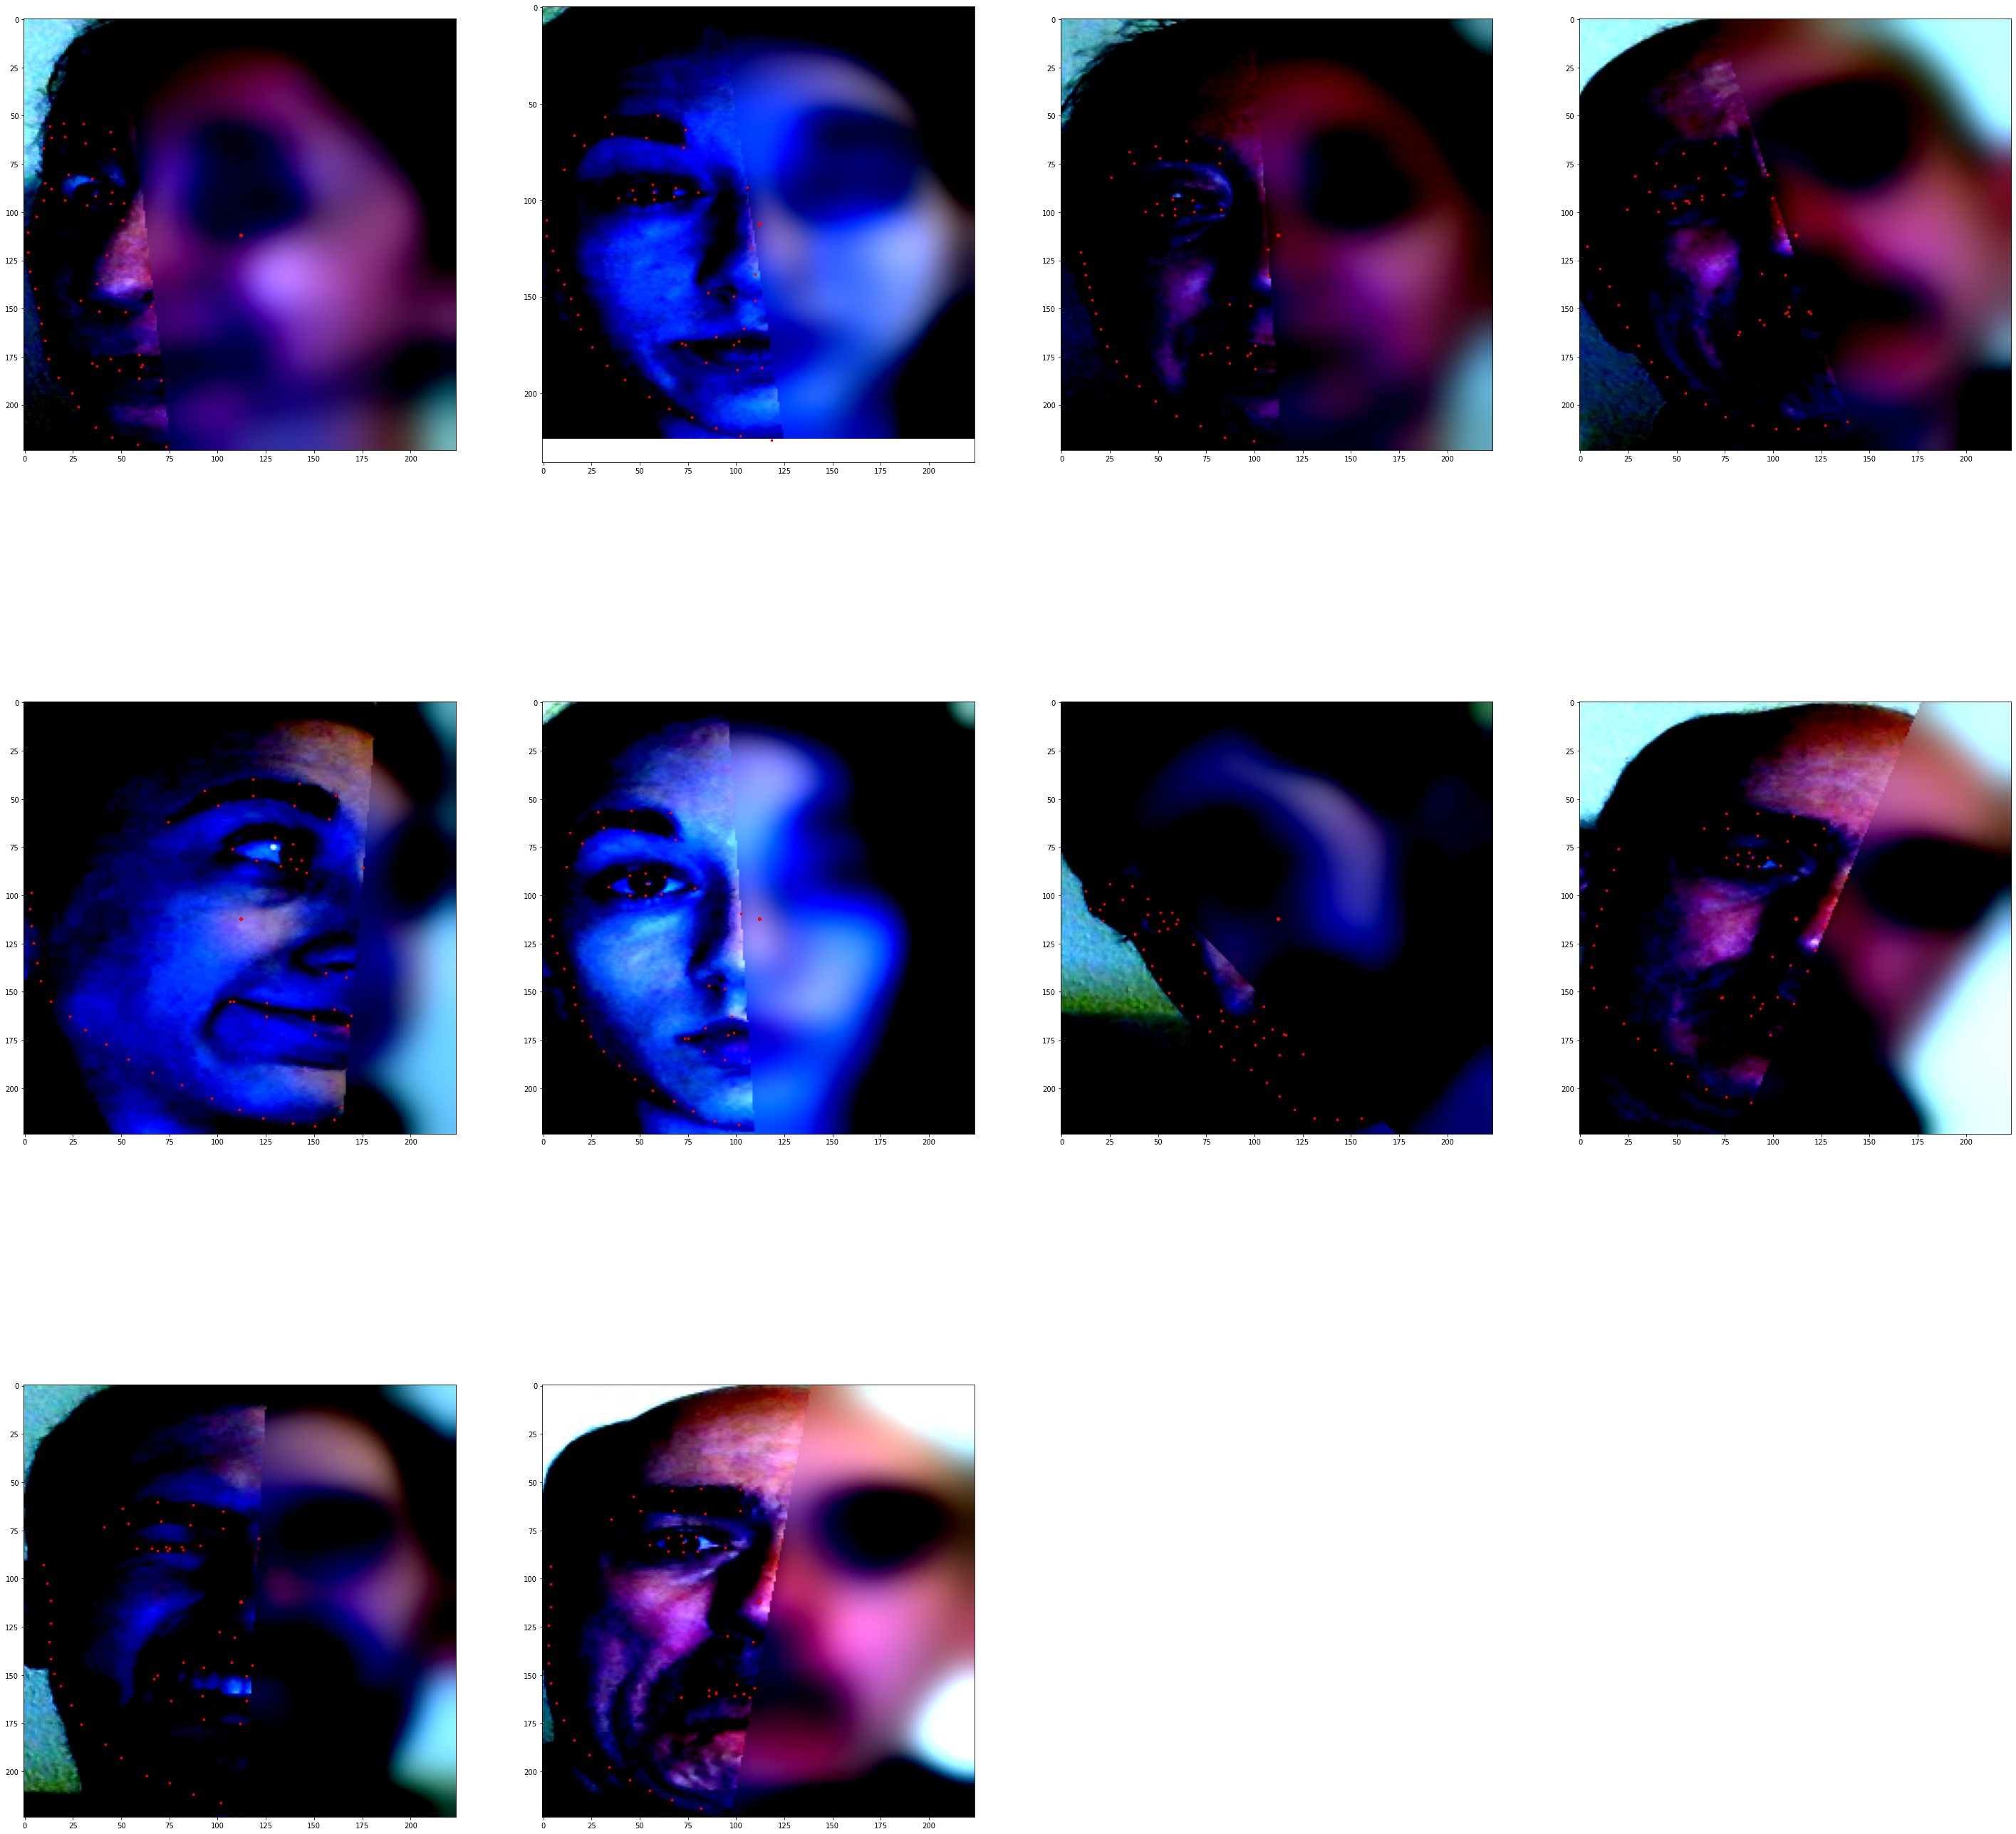

In [18]:
visualize_dataset(test_dataset, 50, 50,10, "right")

# visualize_dataset(dataset, 50, 50)


In [19]:
torch.cuda.is_available()

True

In [20]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Nov__3_21:07:56_CDT_2017
Cuda compilation tools, release 9.1, V9.1.85


#Splitting into the training & validation
#Dataloaders

In [21]:
valid_ratio = 0.1
batch_size = 32

In [22]:
# split the dataset into validation and test sets
len_valid_set = int(valid_ratio*len(dataset))
len_train_set = len(dataset) - len_valid_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))

train_dataset , valid_dataset,  = torch.utils.data.random_split(dataset , [len_train_set, len_valid_set], generator=torch.Generator().manual_seed(42))

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

The length of Train set is 6750
The length of Valid set is 750


In [23]:
train_dataset

In [24]:
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)

# Train

In [ ]:
path_to_model = "experiments/exp_3_y/face_landmarks.pth"


torch.autograd.set_detect_anomaly(True)
network = NetworkResnet18()
network.load_state_dict(torch.load(path_to_model))
network.cuda()    
def freeze_bn(m):
    if isinstance(m, nn.BatchNorm2d):
      m.track_running_stats = False

network = network.apply(freeze_bn)

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 20
best_epoch = 0
start_time = time.time()
lossTrack_train = []
lossTrack_valid = []

nmeTrack_valid = []
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    train_it = iter(train_loader)
    for step in range(1,len(train_loader)+1):
        sample =  next(train_it)
        side = random.getrandbits(1)
        if side == 0: # left
          images, landmarks, full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'], sample['landmarks']
        else: # right
          images, landmarks, full_landmarks = sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
      
        images = images.cuda()

        landmarks = landmarks.cuda() 
        full_landmarks = full_landmarks.cuda() 
        
        predictions = network(images)
        shape = predictions.shape
        predictions = predictions.reshape(-1, 98, 2)

        predictions[landmarks] = full_landmarks[landmarks]
        
        predictions = predictions.reshape(shape)
        full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, full_landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        valid_it = iter(valid_loader)
        for step in range(1,len(valid_loader)+1):
            sample =  next(valid_it)
            # side = random.getrandbits(1)
            # if side == 0: # left
            #   images, landmarks, full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'], sample['landmarks']
            # else: # right
            #   images, landmarks, full_landmarks = sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
            # # images, landmarks = sample['images'] , sample['landmarks']
        
            # images = images.cuda()
            
            # landmarks = landmarks.cuda() 
            # full_landmarks = full_landmarks.cuda() 
            
            # predictions = network(images)
            # shape = predictions.shape
            # predictions = predictions.reshape(-1, 98, 2)

            # predictions[landmarks] = full_landmarks[landmarks]
            
            # predictions = predictions.reshape(shape)
            # full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)
            images, landmarks = sample['images'] , sample['landmarks']
        
            images = images.cuda()

            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    # full_nme = evaluate_model(valid_loader, network, visualize=False)
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    lossTrack_train.append(loss_train)
    lossTrack_valid.append(loss_valid)
    # nmeTrack_valid.append(full_nme)
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        best_epoch = epoch

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
print(f"best model achieved at epoch {best_epoch}")
plt.plot( [*range(1, num_epochs+1, 1)] , lossTrack_train,label='train loss'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,lossTrack_valid, label = "valid loss"   )
plt.legend()
plt.show()
# plt.plot( [*range(1, num_epochs+1, 1)] ,nmeTrack_valid, label='nmeTrack_valid'  )
plt.legend()
plt.show()
files.download( '/content/face_landmarks.pth')


# Resnet18

## Transfer to halves


In [ ]:
path_to_model = "experiments/exp_3_y/face_landmarks.pth"

torch.autograd.set_detect_anomaly(True)
network = NetworkResnet18()
network.load_state_dict(torch.load(path_to_model))
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 100
best_epoch = 0
start_time = time.time()
lossTrack_train = []
lossTrack_valid = []

scheduler = ReduceLROnPlateau(optimizer, 'min')

nmeTrack_valid = []
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    full_nme = 0

    left = 0
    right = 0
    
    network.train()
    train_it = iter(train_loader)
    
    print('Learning rate in the beginnning of training: {:.6f}'.format(optimizer.param_groups[0]['lr']))
    
    for step in range(1, len(train_loader)+1):
        sample =  next(train_it)
        side = random.getrandbits(1)
        if side == 0: # left
          left += 1
          images, landmarks, full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'], sample['landmarks']
        else: # right
          images, landmarks, full_landmarks = sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
          right+= 1
        
        images = images.cuda()

        landmarks = landmarks.cuda() 
        full_landmarks = full_landmarks.cuda() 
        
        predictions = network(images)
        shape = predictions.shape
        predictions = predictions.reshape(-1, 98, 2)

        predictions[landmarks] = full_landmarks[landmarks]
        
        predictions = predictions.reshape(shape)
        full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, full_landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        valid_it = iter(valid_loader)
        for step in range(1,len(valid_loader)+1):
            sample =  next(valid_it)
            images, landmarks = sample['images'] , sample['landmarks']
        
            images = images.cuda()
            print_overwrite(step, len(valid_loader), 0, 'valid')

            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            
            full_nme += NME(predictions.detach().cpu(), landmarks.detach().cpu())

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    full_nme /= len(valid_loader)
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    lossTrack_train.append(loss_train)
    lossTrack_valid.append(loss_valid)
    nmeTrack_valid.append(full_nme)
        
    np.save('loss_train.npy', np.array(lossTrack_train))
    np.save('loss_valid.npy', np.array(lossTrack_valid))
    np.save('nme.npy', np.array(nmeTrack_valid))
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.6f}  Valid Loss: {:.6f}  Left ratio: {}/{}'.format(epoch, loss_train, loss_valid, left, left+right))
    print('--------------------------------------------------')
    scheduler.step(loss_valid)
    print('Learning rate after valid step: {:.6f}'.format(optimizer.param_groups[0]['lr']))

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks_3.pth') 
        print("\nMinimum Validation Loss of {:.6f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        best_epoch = epoch

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
print(f"best model achieved at epoch {best_epoch}")
plt.plot( [*range(1, num_epochs+1, 1)] , lossTrack_train,label='train loss'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,lossTrack_valid, label = "valid loss"   )
plt.legend()
plt.show()
plt.plot( [*range(1, num_epochs+1, 1)] ,nmeTrack_valid, label='nmeTrack_valid'  )
plt.legend()
plt.show()
# files.download( '/content/face_landmarks.pth')

Learning rate in the beginnning of training: 0.000100
Valid Steps: 11/11  Loss: 0.001106 6 
--------------------------------------------------
Epoch: 1  Train Loss: 0.000606  Valid Loss: 0.001106  Left ratio: 51/105
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.001106 at epoch 1/100
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 11/11  Loss: 0.001060 4 
--------------------------------------------------
Epoch: 2  Train Loss: 0.000474  Valid Loss: 0.001060  Left ratio: 65/105
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.001060 at epoch 2/100
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 11/11  Loss: 0.001367 7 
--------------------------------------------------
Epoch: 3  Train Loss: 0.000417  Valid Loss: 0.001367  Left ratio: 52/105
--------------------------------------

Valid Steps: 11/11  Loss: 0.000925 1 
--------------------------------------------------
Epoch: 26  Train Loss: 0.000201  Valid Loss: 0.000925  Left ratio: 47/105
--------------------------------------------------
Learning rate after valid step: 0.000010
Learning rate in the beginnning of training: 0.000010
Valid Steps: 11/11  Loss: 0.000921 8 
--------------------------------------------------
Epoch: 27  Train Loss: 0.000198  Valid Loss: 0.000921  Left ratio: 51/105
--------------------------------------------------
Learning rate after valid step: 0.000010
Learning rate in the beginnning of training: 0.000010
Valid Steps: 11/11  Loss: 0.000987 9 
--------------------------------------------------
Epoch: 28  Train Loss: 0.000199  Valid Loss: 0.000987  Left ratio: 55/105
--------------------------------------------------
Learning rate after valid step: 0.000010
Learning rate in the beginnning of training: 0.000010
Train Steps: 53/105  Loss: 0.000196 

## Mix MSE

In [22]:
print(current_date)

2021-03-14


Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.010806 0 
--------------------------------------------------
Epoch: 1  Train Loss: 0.018470  Valid Loss: 0.010806  Left ratio: 48/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.010806 at epoch 1/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.010527 0 
--------------------------------------------------
Epoch: 2  Train Loss: 0.005980  Valid Loss: 0.010527  Left ratio: 60/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.010527 at epoch 2/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.006287 2 
--------------------------------------------------
Epoch: 3  Train Loss: 0.004592  Valid Loss: 0.006287  Left ratio: 49/210
----------------------------------------

Valid Steps: 23/23  Loss: 0.001702 2 
--------------------------------------------------
Epoch: 25  Train Loss: 0.001112  Valid Loss: 0.001702  Left ratio: 51/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.001646 5 
--------------------------------------------------
Epoch: 26  Train Loss: 0.001195  Valid Loss: 0.001646  Left ratio: 47/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.001453 6 
--------------------------------------------------
Epoch: 27  Train Loss: 0.001106  Valid Loss: 0.001453  Left ratio: 50/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.001453 at epoch 27/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid St

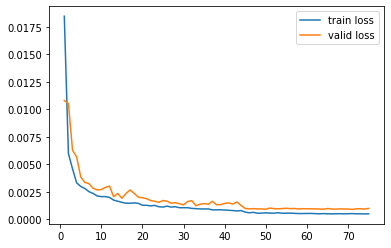

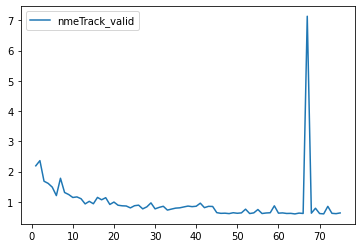

In [21]:
torch.autograd.set_detect_anomaly(True)
network = NetworkResnet18()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 75
best_epoch = 0
start_time = time.time()
lossTrack_train = []
lossTrack_valid = []

scheduler = ReduceLROnPlateau(optimizer, 'min')

nmeTrack_valid = []

current_date = date.today()

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    full_nme = 0

    left = 0
    
    network.train()
    train_it = iter(train_loader)
    
    print('Learning rate in the beginnning of training: {:.6f}'.format(optimizer.param_groups[0]['lr']))
    
    for step in range(1, len(train_loader)+1):
        sample =  next(train_it)
        side = random.getrandbits(2)
        if side == 0: # left
            left += 1
            images, landmarks, full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'], sample['landmarks']
        elif side == 1: # right
            images, landmarks, full_landmarks = sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
        else:
            images, full_landmarks = sample['images'], sample['landmarks']

        images = images.cuda()

        landmarks = landmarks.cuda() 
        full_landmarks = full_landmarks.cuda() 
        
        predictions = network(images)

        if side < 2:
            shape = predictions.shape
            predictions = predictions.reshape(-1, 98, 2)

            predictions[landmarks] = full_landmarks[landmarks]

            predictions = predictions.reshape(shape)
        
        full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, full_landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        valid_it = iter(valid_loader)
        for step in range(1,len(valid_loader)+1):
            sample =  next(valid_it)
            images, landmarks = sample['images'] , sample['landmarks']
        
            images = images.cuda()
            print_overwrite(step, len(valid_loader), 0, 'valid')

            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step
            
            full_nme += NME(predictions.detach().cpu(), landmarks.detach().cpu())

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    full_nme /= len(valid_loader)
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    lossTrack_train.append(loss_train)
    lossTrack_valid.append(loss_valid)
    nmeTrack_valid.append(full_nme)
        
    np.save('loss_train_{}.npy'.format(current_date), np.array(lossTrack_train))
    np.save('loss_valid_{}.npy'.format(current_date), np.array(lossTrack_valid))
    np.save('nme_{}.npy'.format(current_date), np.array(nmeTrack_valid))
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.6f}  Valid Loss: {:.6f}  Left ratio: {}/{}'.format(epoch, loss_train, loss_valid, left, len(train_loader)))
    print('--------------------------------------------------')
    scheduler.step(loss_valid)
    print('Learning rate after valid step: {:.6f}'.format(optimizer.param_groups[0]['lr']))

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks_{}.pth'.format(current_date)) 
        print("\nMinimum Validation Loss of {:.6f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        best_epoch = epoch

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
print(f"best model achieved at epoch {best_epoch}")
plt.plot( [*range(1, num_epochs+1, 1)] , lossTrack_train,label='train loss'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,lossTrack_valid, label = "valid loss"   )
plt.legend()
plt.show()
plt.plot( [*range(1, num_epochs+1, 1)] ,nmeTrack_valid, label='nmeTrack_valid'  )
plt.legend()
plt.show()

## Mix Wing

2021-03-15
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.364567 4 
--------------------------------------------------
Epoch: 1  Train Loss: 0.363284  Valid Loss: 0.364567  Left ratio: 44/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.364567 at epoch 1/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.332784 9 
--------------------------------------------------
Epoch: 2  Train Loss: 0.214309  Valid Loss: 0.332784  Left ratio: 64/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.332784 at epoch 2/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.263997 0 
--------------------------------------------------
Epoch: 3  Train Loss: 0.184100  Valid Loss: 0.263997  Left ratio: 55/210
-----------------------------

Valid Steps: 23/23  Loss: 0.148984 7 
--------------------------------------------------
Epoch: 25  Train Loss: 0.096417  Valid Loss: 0.148984  Left ratio: 65/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.132588 5 
--------------------------------------------------
Epoch: 26  Train Loss: 0.089935  Valid Loss: 0.132588  Left ratio: 57/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.117787 9 
--------------------------------------------------
Epoch: 27  Train Loss: 0.091579  Valid Loss: 0.117787  Left ratio: 62/210
--------------------------------------------------
Learning rate after valid step: 0.000100

Minimum Validation Loss of 0.117787 at epoch 27/75
Model Saved

Learning rate in the beginnning of training: 0.000100
Valid St

Valid Steps: 23/23  Loss: 0.109312 3 
--------------------------------------------------
Epoch: 51  Train Loss: 0.075693  Valid Loss: 0.109312  Left ratio: 55/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.108115 7 
--------------------------------------------------
Epoch: 52  Train Loss: 0.074497  Valid Loss: 0.108115  Left ratio: 61/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.109317 0 
--------------------------------------------------
Epoch: 53  Train Loss: 0.072490  Valid Loss: 0.109317  Left ratio: 53/210
--------------------------------------------------
Learning rate after valid step: 0.000100
Learning rate in the beginnning of training: 0.000100
Valid Steps: 23/23  Loss: 0.102295 2 
-----------------------------------

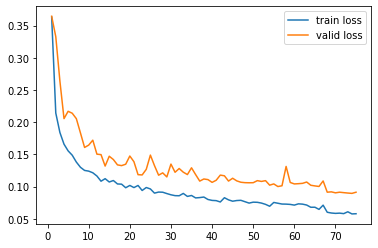

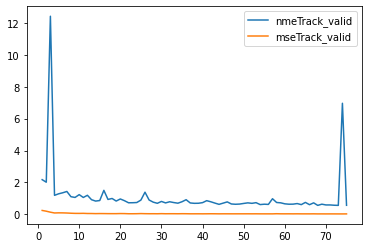

In [22]:
torch.autograd.set_detect_anomaly(True)
network = NetworkResnet18()
network.cuda()

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 75
best_epoch = 0
start_time = time.time()
lossTrack_train = []
lossTrack_valid = []

scheduler = ReduceLROnPlateau(optimizer, 'min')

nmeTrack_valid = []
mseTrack_valid = []

current_date = date.today()
print(current_date)

for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    full_nme = 0
    mse_loss_valid = 0
    left = 0
    
    network.train()
    train_it = iter(train_loader)
    
    print('Learning rate in the beginnning of training: {:.6f}'.format(optimizer.param_groups[0]['lr']))
    
    for step in range(1, len(train_loader)+1):
        sample =  next(train_it)
        side = random.getrandbits(2)
        if side == 0: # left
            left += 1
            images, landmarks, full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'], sample['landmarks']
        elif side == 1: # right
            images, landmarks, full_landmarks = sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
        else:
            images, full_landmarks = sample['images'], sample['landmarks']

        images = images.cuda()

        landmarks = landmarks.cuda() 
        full_landmarks = full_landmarks.cuda() 
        
        predictions = network(images)

        if side < 2:
            shape = predictions.shape
            predictions = predictions.reshape(-1, 98, 2)

            predictions[landmarks] = full_landmarks[landmarks]

            predictions = predictions.reshape(shape)
        
        full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
#         loss_train_step = criterion(predictions, full_landmarks)
        loss_train_step = WingLoss(predictions, full_landmarks)

        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        valid_it = iter(valid_loader)
        for step in range(1,len(valid_loader)+1):
            sample =  next(valid_it)
            images, landmarks = sample['images'] , sample['landmarks']
        
            images = images.cuda()
            print_overwrite(step, len(valid_loader), 0, 'valid')

            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            mse_loss_valid_step = criterion(predictions, landmarks)
            wing_loss_valid_step = WingLoss(predictions, landmarks)

            loss_valid += wing_loss_valid_step
            running_loss = loss_valid/step
            
            full_nme += NME(predictions.detach().cpu(), landmarks.detach().cpu())
            mse_loss_valid += mse_loss_valid_step.item()
            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    full_nme /= len(valid_loader)
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    lossTrack_train.append(loss_train)
    lossTrack_valid.append(loss_valid)
    nmeTrack_valid.append(full_nme)
    mseTrack_valid.append(mse_loss_valid)
        
    np.save('loss_train_{}.npy'.format(current_date), np.array(lossTrack_train))
    np.save('loss_valid_{}.npy'.format(current_date), np.array(lossTrack_valid))
    np.save('nme_{}.npy'.format(current_date), np.array(nmeTrack_valid))
    np.save('mse_{}.npy'.format(current_date), np.array(mseTrack_valid))
    
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.6f}  Valid Loss: {:.6f}  Left ratio: {}/{}'.format(epoch, loss_train, loss_valid, left, len(train_loader)))
    print('--------------------------------------------------')
    scheduler.step(loss_valid)
    print('Learning rate after valid step: {:.6f}'.format(optimizer.param_groups[0]['lr']))

    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), 'face_landmarks_{}.pth'.format(current_date)) 
        print("\nMinimum Validation Loss of {:.6f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        best_epoch = epoch

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
print(f"best model achieved at epoch {best_epoch}")
plt.plot( [*range(1, num_epochs+1, 1)] , lossTrack_train,label='train loss'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,lossTrack_valid, label = "valid loss"   )
plt.legend()
plt.show()
plt.plot( [*range(1, num_epochs+1, 1)] ,nmeTrack_valid, label='nmeTrack_valid'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,mseTrack_valid, label='mseTrack_valid'  )
plt.legend()
plt.show()

# Predict on Test Images

In [19]:
print(len(test_loader), len(test_dataset)) 
len(test_loader.dataset)

6 90


90

In [20]:
path_to_model = "face_landmarks_3.pth"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of test images: 90
Full error:  0.99827296
0.99827296


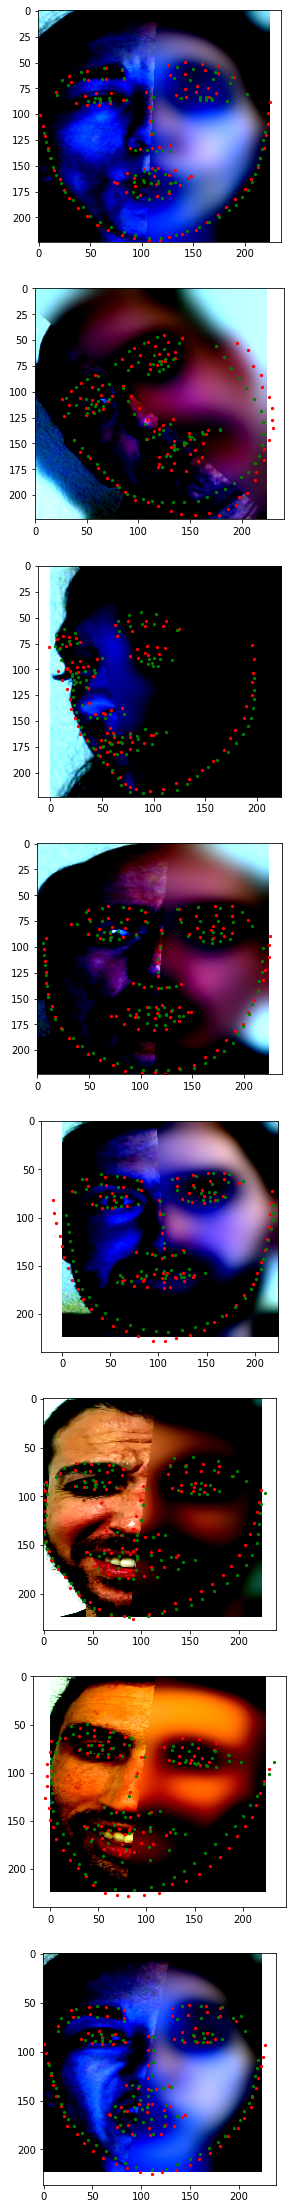

In [22]:
best_network = NetworkResnet18()
best_network.cuda() 
best_network.load_state_dict(torch.load(path_to_model))
print(evaluate_model(test_loader, best_network, visualize=True))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of test images: 90
Full error:  0.89615935
0.89615935


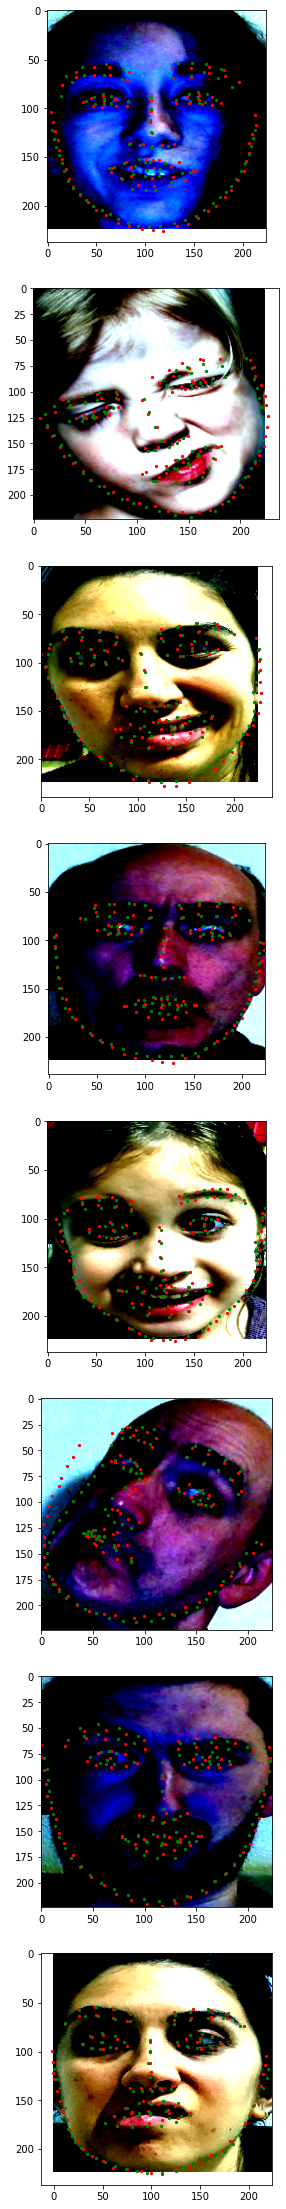

In [24]:
best_network = NetworkResnet18()
best_network.cuda() 
best_network.load_state_dict(torch.load(path_to_model))
print(evaluate_model(test_loader, best_network, visualize=True))

2021-03-14


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of test images: 90
Full error:  0.9499877
0.9499877


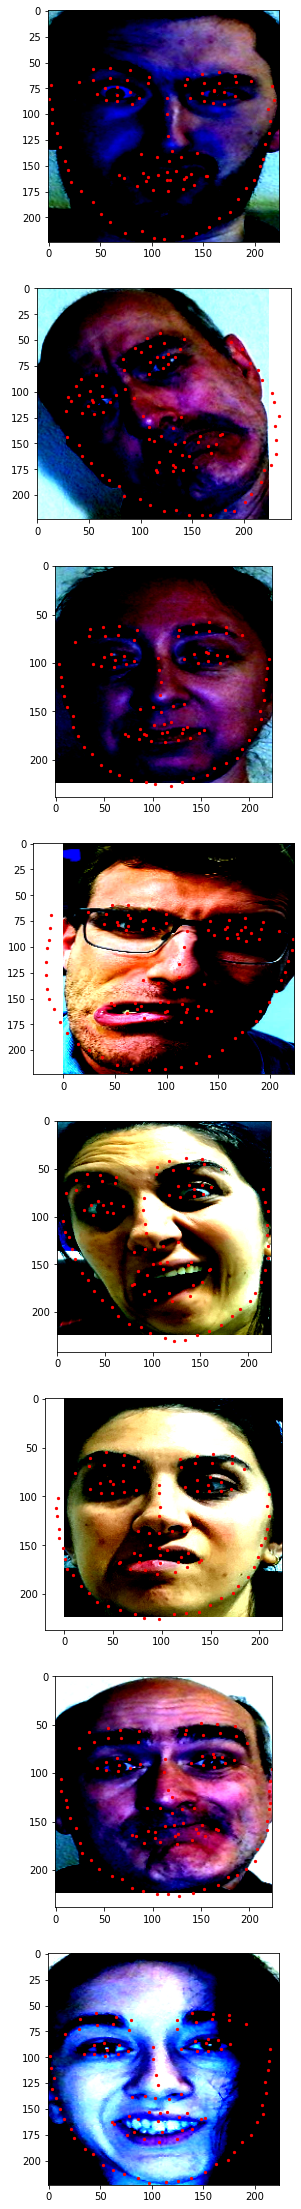

In [26]:
print(current_date)
path_to_model = 'face_landmarks_{}.pth'.format(current_date)
best_network = NetworkResnet18()
best_network.cuda() 
best_network.load_state_dict(torch.load(path_to_model))
print(evaluate_model(test_loader, best_network, visualize=True))

In [ ]:
path_to_model = "experiments/exp_3_y/face_landmarks.pth"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total number of test images: 39
Full error:  0.75802535
Half error:  0.52773035
(0.75802535, 0.52773035)


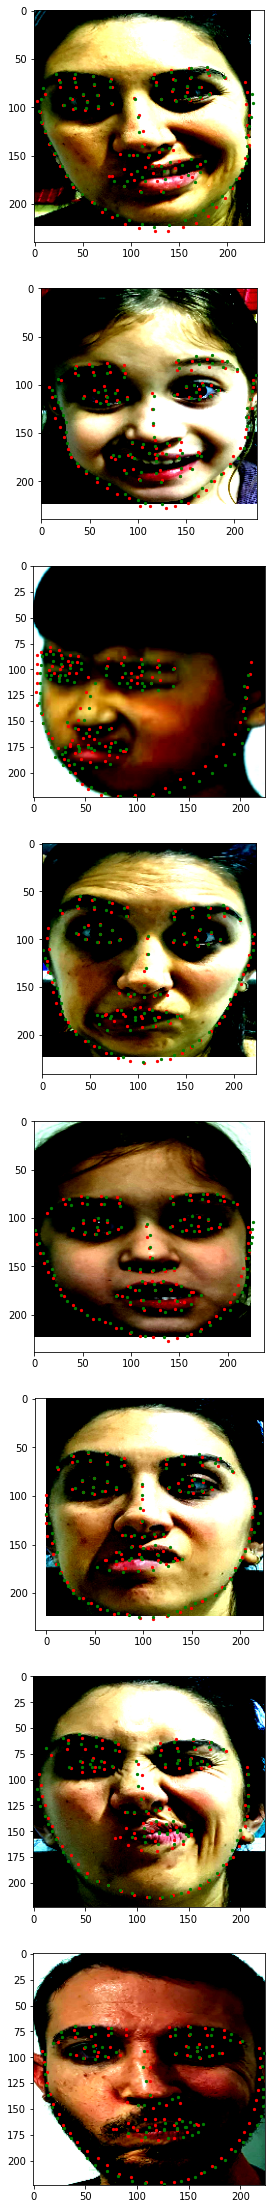

In [ ]:
best_network = NetworkResnet18()
best_network.cuda()
best_network.load_state_dict(torch.load(path_to_model)) 
print(evaluate_model(test_loader, best_network, visualize=True))

Train a semi siamis

Valid Steps: 93/93  Loss: 0.009553 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0015  Valid Loss: 0.0096
--------------------------------------------------

Minimum Validation Loss of 0.0096 at epoch 1/20
Model Saved

Valid Steps: 93/93  Loss: 0.007534 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0014  Valid Loss: 0.0075
--------------------------------------------------

Minimum Validation Loss of 0.0075 at epoch 2/20
Model Saved

Valid Steps: 93/93  Loss: 0.005388 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0012  Valid Loss: 0.0054
--------------------------------------------------

Minimum Validation Loss of 0.0054 at epoch 3/20
Model Saved

Valid Steps: 93/93  Loss: 0.005171 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0012  Valid Loss: 0.0052
--------------------------------------------------

Minimum Validation Loss of 0.0052 at epoch 4/20
Model Saved

Vali

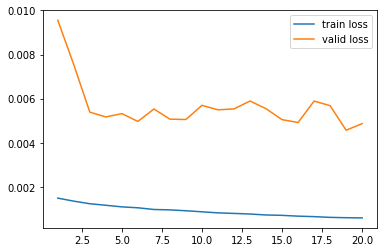

No handles with labels found to put in legend.


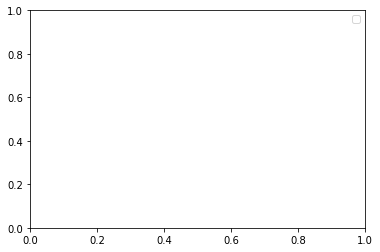

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
path_to_model = "face_landmarks.pth"
torch.autograd.set_detect_anomaly(True)
network = NetworkResnet18()
network.load_state_dict(torch.load(path_to_model))
network.cuda()    
# def freeze_bn(m):
#     if isinstance(m, nn.BatchNorm2d):
#       m.track_running_stats = False

# network = network.apply(freeze_bn)

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 20
best_epoch = 0
start_time = time.time()
lossTrack_train = []
lossTrack_valid = []

nmeTrack_valid = []
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    train_it = iter(train_loader)
    for step in range(1,len(train_loader)+1):
        tmp_full_from_halfs =  torch.zeros(batch_size, 98,2).cuda()

        sample =  next(train_it)
        side = random.getrandbits(1)
        Limages, Llandmarks, Rimages, Rlandmarks,full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'],  sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
        
        full_landmarks = full_landmarks.cuda() 

        #left side
        Limages = Limages.cuda()
        Llandmarks = Llandmarks.cuda()       
        Lpredictions = network(Limages)
        shape = Lpredictions.shape
        Lpredictions = Lpredictions.reshape(-1, 98, 2)

        tmp_full_from_halfs[ Rlandmarks] = Lpredictions[Rlandmarks]

        Rimages = Rimages.cuda()
        Rlandmarks = Rlandmarks.cuda()       
        Rpredictions = network(Rimages)
        shape = Rpredictions.shape
        Rpredictions = Rpredictions.reshape(-1, 98, 2)

        tmp_full_from_halfs[ Llandmarks] = Rpredictions[Llandmarks]

        
        tmp_full_from_halfs = tmp_full_from_halfs.reshape(shape)
        full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)

        # clear all the gradients before calculating them
        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(tmp_full_from_halfs, full_landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        valid_it = iter(valid_loader)
        for step in range(1,len(valid_loader)+1):
            # sample =  next(valid_it)
            # images, landmarks = sample['images'] , sample['landmarks']
        
            # images = images.cuda()

            # landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            # predictions = network(images)

            tmp_full_from_halfs =  torch.zeros(batch_size, 98,2).cuda()

            sample =  next(valid_it)
            side = random.getrandbits(1)
            Limages, Llandmarks, Rimages, Rlandmarks,full_landmarks = sample['images_occlude_left'], sample['landmarks_occlude_left'],  sample['images_occlude_right'], sample['landmarks_occlude_right'], sample['landmarks']
            
            full_landmarks = full_landmarks.cuda() 

            #left side
            Limages = Limages.cuda()
            Llandmarks = Llandmarks.cuda()       
            Lpredictions = network(Limages)
            shape = Lpredictions.shape
            Lpredictions = Lpredictions.reshape(-1, 98, 2)

            tmp_full_from_halfs[ Rlandmarks] = Lpredictions[Rlandmarks]

            Rimages = Rimages.cuda()
            Rlandmarks = Rlandmarks.cuda()       
            Rpredictions = network(Rimages)
            shape = Rpredictions.shape
            Rpredictions = Rpredictions.reshape(-1, 98, 2)

            tmp_full_from_halfs[ Llandmarks] = Rpredictions[Llandmarks]

            
            tmp_full_from_halfs = tmp_full_from_halfs.reshape(shape)
            full_landmarks = full_landmarks.view(full_landmarks.size(0),-1)



            # find the loss for the current step
            loss_valid_step = criterion(tmp_full_from_halfs, full_landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    # full_nme = evaluate_model(valid_loader, network, visualize=False)
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    lossTrack_train.append(loss_train)
    lossTrack_valid.append(loss_valid)
    # nmeTrack_valid.append(full_nme)
    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')
        best_epoch = epoch

print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))
print(f"best model achieved at epoch {best_epoch}")
plt.plot( [*range(1, num_epochs+1, 1)] , lossTrack_train,label='train loss'  )
plt.plot( [*range(1, num_epochs+1, 1)] ,lossTrack_valid, label = "valid loss"   )
plt.legend()
plt.show()
# plt.plot( [*range(1, num_epochs+1, 1)] ,nmeTrack_valid, label='nmeTrack_valid'  )
plt.legend()
plt.show()
files.download( '/content/face_landmarks.pth')
